# ⤵️Import Libraries 

In [1]:
import os
import re
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go

import xlrd
import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

In [2]:
col_pal = ['#8236CB', 
           '#EB2632']

# ⚙️Functions

In [12]:
## Plot the confusion matrics and print class wise performance metrics
def performance_metrics(y_pred, y_test, y_train, model):
    
    ## confusion matrix
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    cnf_matrix_df = pd.DataFrame(cnf_matrix, 
                             columns=['Predicted Negative', 'Predicted Positive'], 
                             index=['Actual Negative', 'Actual Positive'])

    #metrics_df = metrics(cnf_matrix_df)  

    class_names = list(np.unique(y_train)) # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    ## create heatmap
    sns.heatmap(cnf_matrix_df, 
                annot=True, 
                cmap="YlGnBu", 
                fmt='g')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    ax.xaxis.set_label_position("bottom")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(f'Confusion Matrix_{model}.png')
    
    accuracy = round(metrics.accuracy_score(y_test, y_pred)*100, 2)

    print("Accuracy:",accuracy)
    
    ## classification report
    LabelScore = metrics.classification_report(y_pred, y_test, output_dict=True)
    df = pd.DataFrame(LabelScore).T
    df.drop(['support'], inplace=True, axis=1)
    df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True, axis=0)
    df = df.rename(columns={'precision' : 'Precision', 'recall' : 'Recall'}, index={'0' : 'Non-Persistent', '1' : 'Persistent'})
    return df.round(2) 

# 📂Load Data

In [4]:
os.chdir('..')
curr_dir = (os.getcwd()).replace('\\', '/')
file_path = curr_dir + '/Dataset/Prcsd_Healthcare_dataset.xlsx'

In [119]:
drug_df = pd.read_excel(file_path)

In [7]:
drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 66 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   persistency_flag                                                    3424 non-null   object 
 1   region                                                              3424 non-null   object 
 2   age_bucket                                                          3424 non-null   object 
 3   ntm_specialist_flag                                                 3424 non-null   object 
 4   ntm_speciality_bucket                                               3424 non-null   object 
 5   gluco_record_prior_ntm                                              3424 non-null   object 
 6   gluco_record_during_rx                                              3424 non-null   object 
 7   dexa_freq_durin

# 📋Feature Selection

In [121]:
target = drug_df['persistency_flag']
drug_df.drop(['persistency_flag'], 
             axis=1, 
             inplace=True)

In [122]:
drug_df.columns

Index(['region', 'age_bucket', 'ntm_specialist_flag', 'ntm_speciality_bucket',
       'gluco_record_prior_ntm', 'gluco_record_during_rx',
       'dexa_freq_during_rx', 'dexa_during_rx', 'frag_frac_prior_ntm',
       'frag_frac_during_rx', 'risk_segment_prior_ntm',
       'tscore_bucket_prior_ntm', 'risk_segment_during_rx',
       'tscore_bucket_during_rx', 'change_t_score', 'change_risk_segment',
       'adherent_flag', 'idn_indicator', 'injectable_experience_during_rx',
       'comorb_encounter_for_screening_for_malignant_neoplasms',
       'comorb_encounter_for_immunization',
       'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx',
       'comorb_vitamin_d_deficiency',
       'comorb_other_joint_disorder_not_elsewhere_classified',
       'comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx',
       'comorb_long_term_current_drug_therapy', 'comorb_dorsalgia',
       'comorb_personal_history_of_other_diseases_and_conditions',
       'comorb_other_disorde

## Convert categorical to numerical 

In [123]:
dexa_col = drug_df[['dexa_freq_during_rx_bc']]
drug_df['count_of_risks_upd'] = drug_df['count_of_risks_upd'].astype(str)
X = drug_df.drop(['dexa_freq_during_rx', 'dexa_freq_during_rx_win', 'dexa_freq_during_rx_bc'], axis=1)

In [124]:
lbl_enc = LabelEncoder()
X = X.apply(lbl_enc.fit_transform)
X.head()

,region,age_bucket,ntm_specialist_flag,ntm_speciality_bucket,gluco_record_prior_ntm,gluco_record_during_rx,dexa_during_rx,frag_frac_prior_ntm,frag_frac_during_rx,risk_segment_prior_ntm,...,risk_family_history_of_osteoporosis,risk_low_calcium_intake,risk_vitamin_d_insufficiency,risk_poor_health_frailty,risk_excessive_thinness,risk_hysterectomy_oophorectomy,risk_estrogen_deficiency,risk_immobilization,risk_recurring_falls,count_of_risks_upd
0,4,3,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
3,0,3,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,3,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [126]:
X = pd.concat([X, dexa_col], axis=1)

In [127]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 63 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   region                                                              3424 non-null   int32  
 1   age_bucket                                                          3424 non-null   int32  
 2   ntm_specialist_flag                                                 3424 non-null   int32  
 3   ntm_speciality_bucket                                               3424 non-null   int32  
 4   gluco_record_prior_ntm                                              3424 non-null   int32  
 5   gluco_record_during_rx                                              3424 non-null   int32  
 6   dexa_during_rx                                                      3424 non-null   int32  
 7   frag_frac_prior

In [128]:
target = lbl_enc.fit_transform(target)
target

array([1, 0, 0, ..., 1, 0, 0])

## 1. RFECV 

> - **Random Forest Classifier**

In [55]:
rfc = RandomForestClassifier()
rfecv_rfc = RFECV(estimator=rfc, 
                  step=1, 
                  cv=StratifiedKFold(10), 
                  scoring='accuracy')
rfecv_rfc.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(), scoring='accuracy')

In [56]:
print('Optimal number of features: {}'.format(rfecv_rfc.n_features_))

Optimal number of features: 55


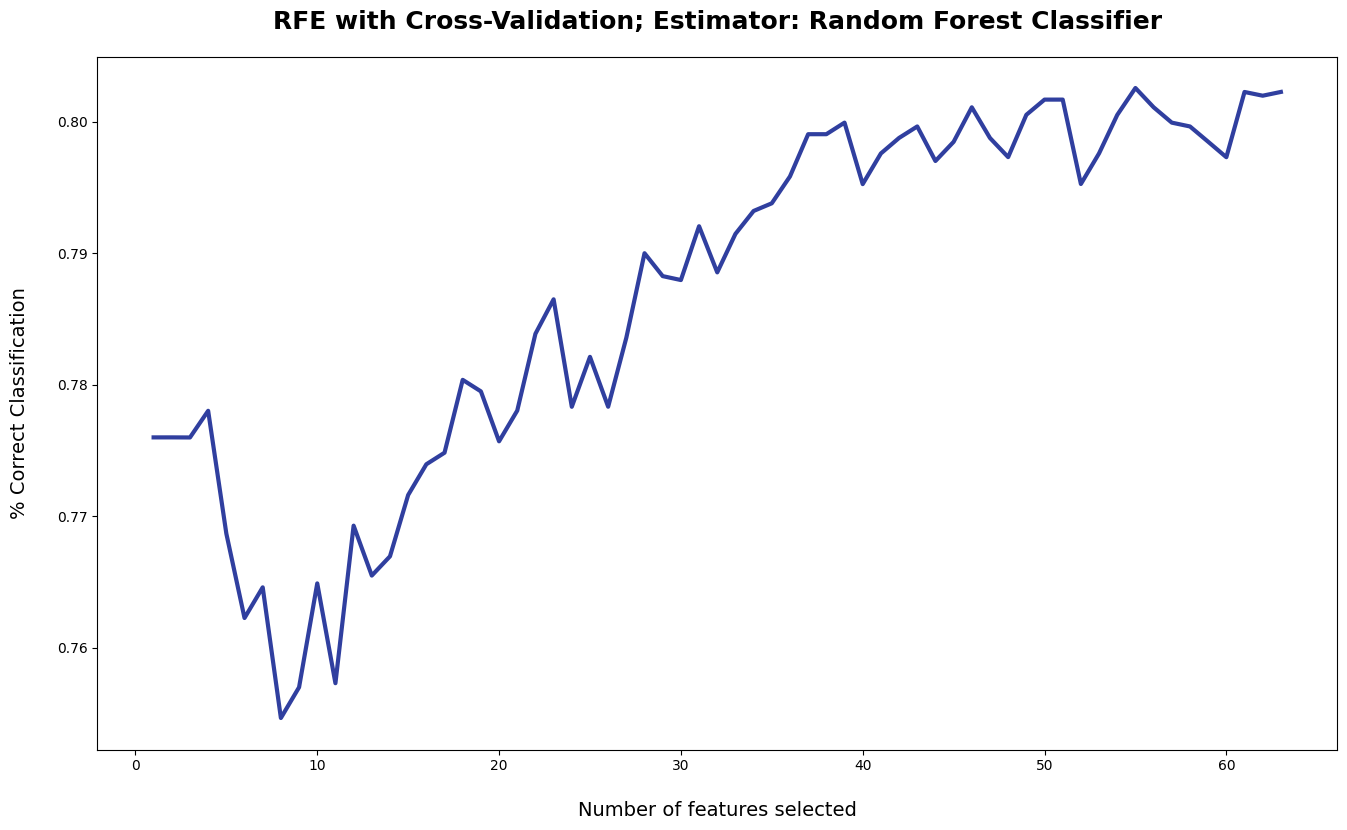

In [57]:
plt.figure(figsize=(16, 9))
plt.title('RFE with Cross-Validation; Estimator: Random Forest Classifier', 
          fontsize=18, 
          fontweight='bold', 
          pad=20)
plt.xlabel('Number of features selected', 
           fontsize=14, 
           labelpad=20)
plt.ylabel('% Correct Classification', 
           fontsize=14, 
           labelpad=20)
plt.plot(range(1, len(rfecv_rfc.cv_results_['mean_test_score']) + 1), 
         rfecv_rfc.cv_results_['mean_test_score'], 
         color='#303F9F', 
         linewidth=3)

plt.show()

In [58]:
X_rfc = X.drop(X.columns[np.where(rfecv_rfc.support_ == False)[0]], axis=1)

Text(0.5, 1.0, 'Feature Importance; Estimator: Random Forest Classifier')

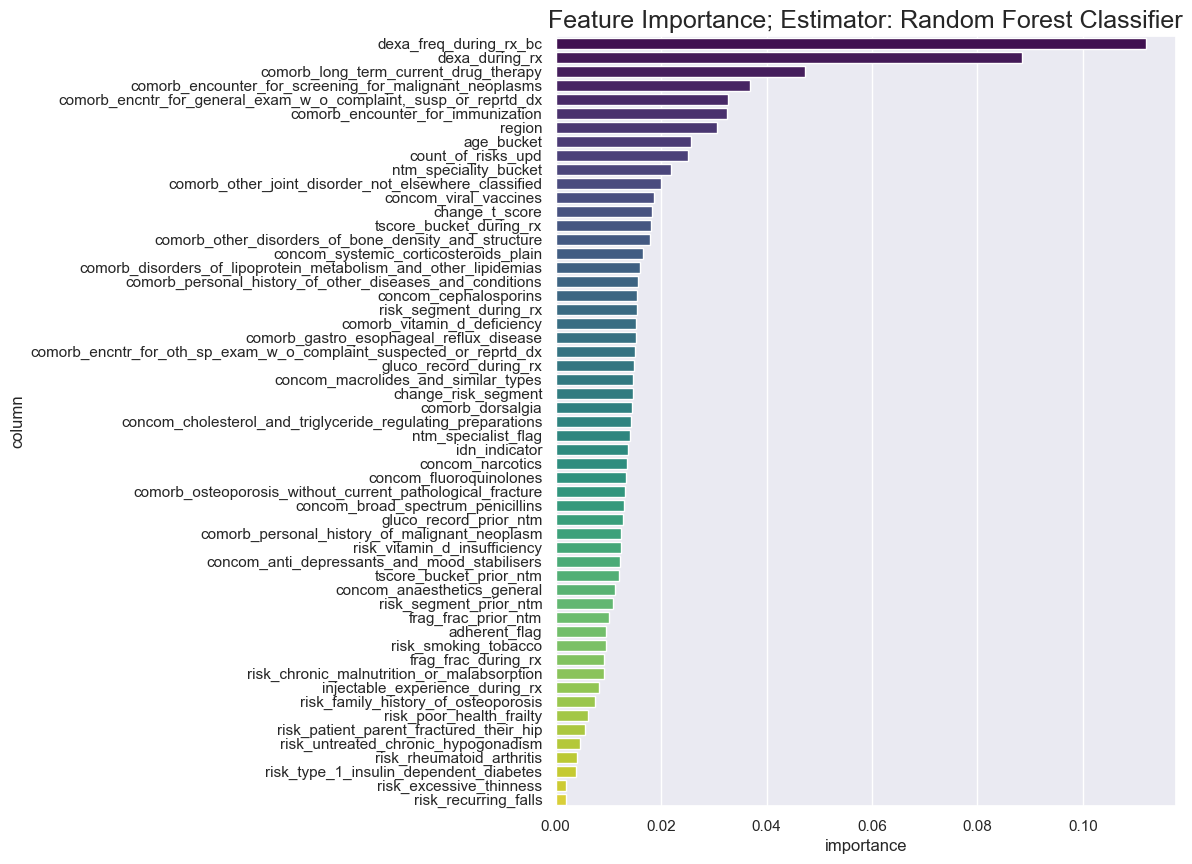

In [59]:
rfc_est_df = pd.DataFrame()

rfc_est_df['column'] = X_rfc.columns
rfc_est_df['importance'] = rfecv_rfc.estimator_.feature_importances_

rfc_est_df.sort_values(by='importance', 
                       ascending=False, 
                       inplace=True, 
                       ignore_index=True)

sns.set(rc = {'figure.figsize':(8,10)})
ax = sns.barplot(y='column', 
                 x='importance',
                 data=rfc_est_df,
                 palette='viridis')

ax.set_title('Feature Importance; Estimator: Random Forest Classifier', 
             fontsize=18)

Here, as observed from feature importance scores, there is almost steady decrease in importance score after *ntm_speciality_bucket*. Hence, we will select features upto this feature.

In [60]:
X_rfc = X_rfc[['dexa_freq_during_rx_bc', 'dexa_during_rx', 'comorb_long_term_current_drug_therapy', 'age_bucket',
               'comorb_encounter_for_immunization', 'comorb_encounter_for_screening_for_malignant_neoplasms', 'region', 
               'ntm_speciality_bucket', 'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx', 
               'count_of_risks_upd']]

In [61]:
X_rfc['persistency_flag'] = target.tolist()

rfecv_rfc_fp = curr_dir + '/Dataset/RFECV_RFC_Healthcare_dataset.xlsx'
X_rfc.to_excel(rfecv_rfc_fp, index=False)

In [90]:
rfecv_rfc_fp = curr_dir + '/Dataset/RFECV_RFC_Healthcare_dataset.xlsx'
X_rfc = pd.read_excel(rfecv_rfc_fp)

> - **Logistic Regression**

In [63]:
lr = LogisticRegression()
rfecv_lr = RFECV(estimator=lr, 
                step=1, 
                cv=StratifiedKFold(10), 
                scoring='accuracy')
rfecv_lr.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(), scoring='accuracy')

In [64]:
print('Optimal number of features: {}'.format(rfecv_lr.n_features_))

Optimal number of features: 56


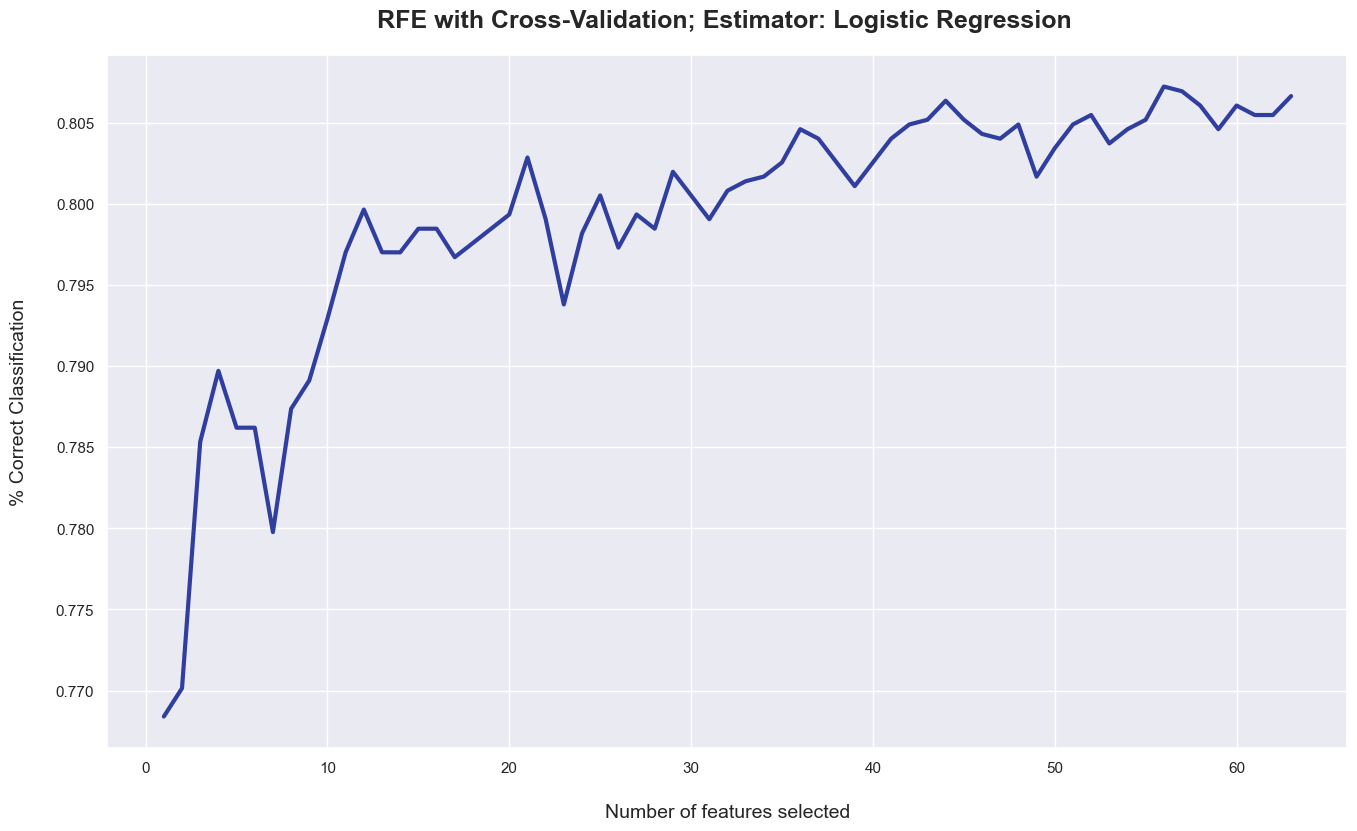

In [65]:
plt.figure(figsize=(16, 9))
plt.title('RFE with Cross-Validation; Estimator: Logistic Regression ', 
          fontsize=18, 
          fontweight='bold', 
          pad=20)
plt.xlabel('Number of features selected', 
           fontsize=14, 
           labelpad=20)
plt.ylabel('% Correct Classification', 
           fontsize=14, 
           labelpad=20)
plt.plot(range(1, len(rfecv_lr.cv_results_['mean_test_score']) + 1), 
         rfecv_lr.cv_results_['mean_test_score'], 
         color='#303F9F', 
         linewidth=3)

plt.show()

In [66]:
rfecv_lr.estimator_.coef_[0]

array([ 0.11287138,  0.08971519,  0.37070446, -0.26321166, -0.56419536,
        0.10215008, -0.12687032, -0.36274746,  0.19752921,  0.16947254,
       -0.09931057, -0.11671834, -0.2570003 , -0.15851283,  0.41805876,
        0.28605092,  0.39566004,  0.57986646,  0.3800094 ,  0.61999632,
        0.76063172,  0.39559294,  0.17693315,  0.95428774,  0.32263489,
        0.2095942 ,  0.75601667, -0.29579296,  0.21420999,  0.36762398,
       -0.30316252,  0.53322392,  0.30069641,  0.24932801,  0.2935351 ,
        0.47193223,  0.21094388,  0.92470732, -0.74395398,  0.36161762,
       -0.4221388 ,  0.88336413,  0.20285847,  0.31181856,  0.2914731 ,
        0.17036095,  0.33004859, -0.13384836, -0.78938937, -0.44075462,
       -0.13515766, -0.4730432 , -0.55248469, -0.79110223, -0.27076454,
        3.02746157])

In [68]:
X_lr = X.drop(X.columns[np.where(rfecv_lr.support_ == False)[0]], axis=1)

Text(0.5, 1.0, 'Feature Importance; Estimator: Logistic Regression')

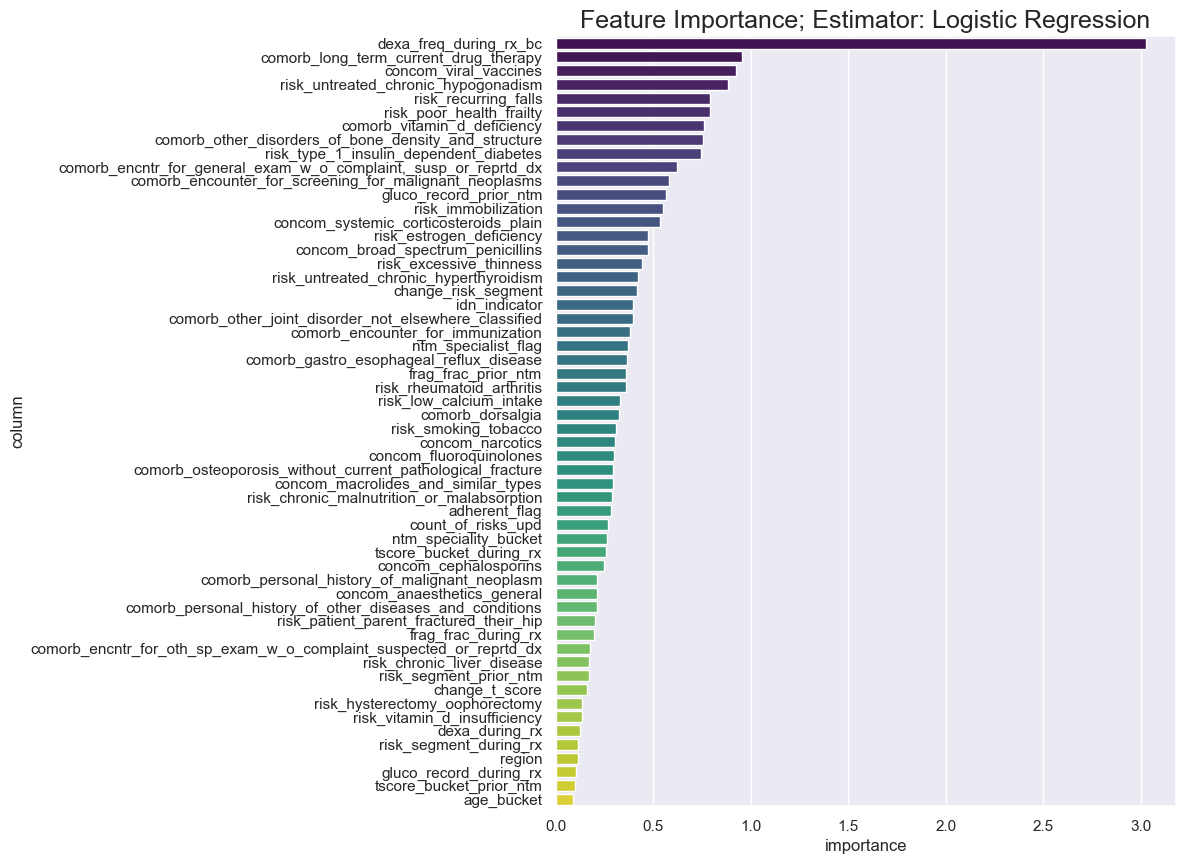

In [69]:
lr_est_df = pd.DataFrame()

lr_est_df['column'] = X_lr.columns
lr_est_df['importance'] = np.abs(rfecv_lr.estimator_.coef_[0])

lr_est_df.sort_values(by='importance', 
                      ascending=False, 
                      inplace=True, 
                      ignore_index=True)

sns.set(rc = {'figure.figsize':(8,10)})
ax = sns.barplot(y='column', 
                 x='importance',
                 data=lr_est_df,
                 palette='viridis')
ax.set_title('Feature Importance; Estimator: Logistic Regression', 
             fontsize=18)

In the above plot, when we observe the descrease in the importance score, a steady decrease can be seen after a score of **0.5** which is *concom_systemic_corticosteroids_plain* feature. Hence, we will select tall the features above this.

In [ ]:
X_lr = X_lr[['comorb_long_term_current_drug_therapy', 'comorb_encounter_for_screening_for_malignant_neoplasms',
             'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx', 'risk_recurring_falls', 'dexa_during_rx',
             'risk_poor_health_frailty', 'risk_type_1_insulin_dependent_diabetes', 'concom_viral_vaccines', 
             'comorb_vitamin_d_deficiency', 'comorb_other_disorders_of_bone_density_and_structure', 'dexa_freq_during_rx_bc',
             'risk_untreated_chronic_hypogonadism', 'risk_immobilization', 'risk_excessive_thinness', 
             'risk_estrogen_deficiency', 'gluco_record_prior_ntm', 'concom_systemic_corticosteroids_plain']]

In [71]:
X_lr['persistency_flag'] = target.tolist()

rfecv_lr_fp = curr_dir + '/Dataset/RFECV_LR_Healthcare_dataset.xlsx'
X_lr.to_excel(rfecv_lr_fp, index=False)

In [6]:
rfecv_lr_fp = curr_dir + '/Dataset/RFECV_LR_Healthcare_dataset.xlsx'
X_lr = pd.read_excel(rfecv_lr_fp)

## 2. Feature Selection based on EDA 

In [129]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 63 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   region                                                              3424 non-null   int32  
 1   age_bucket                                                          3424 non-null   int32  
 2   ntm_specialist_flag                                                 3424 non-null   int32  
 3   ntm_speciality_bucket                                               3424 non-null   int32  
 4   gluco_record_prior_ntm                                              3424 non-null   int32  
 5   gluco_record_during_rx                                              3424 non-null   int32  
 6   dexa_during_rx                                                      3424 non-null   int32  
 7   frag_frac_prior

In [131]:
col_to_drp = ['ntm_specialist_flag', 'frag_frac_prior_ntm', 'frag_frac_during_rx', 'risk_segment_prior_ntm', 
              'tscore_bucket_prior_ntm', 'risk_segment_during_rx', 'tscore_bucket_during_rx', 'change_t_score', 
              'change_risk_segment', 'adherent_flag', 'idn_indicator', 'injectable_experience_during_rx', 
              'risk_type_1_insulin_dependent_diabetes', 'risk_osteogenesis_imperfecta', 'risk_rheumatoid_arthritis', 
              'risk_untreated_chronic_hyperthyroidism', 'risk_untreated_chronic_hypogonadism', 'risk_untreated_early_menopause',
              'risk_patient_parent_fractured_their_hip']

X_uptd = X.drop(col_to_drp, axis=1)

# 🏤Model Building/Selection

## 1. Features selected from RFECV: Random Forest

#### Split the Dataset 

In [91]:
target = X_rfc['persistency_flag']
X_rfc.drop('persistency_flag', 
           axis=1, 
           inplace=True)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_rfc, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [25]:
sm = SMOTE(random_state=42,
           n_jobs=-1)

In [26]:
X_train, y_train = sm.fit_resample(X_train, 
                                   y_train)

## Linear Models 

### Logistic Regression

In [99]:
param_grid = [{
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear'],
    'C' : [1, 10],
}]

lr = LogisticRegression()

lr_grid_model = GridSearchCV(lr, 
                             param_grid, 
                             n_jobs=-1, 
                             scoring='accuracy',
                             cv=5, 
                             verbose=2)

lr_grid_model.fit(X_train, 
                  y_train)

best_params = lr_grid_model.best_params_
print(best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [100]:
lr  = LogisticRegression(**best_params)
lr_model = lr.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test) 

Accuracy: 77.52


,Precision,Recall,f1-score
Non-Persistent,0.90,0.78,0.83
Persistent,0.57,0.76,0.65


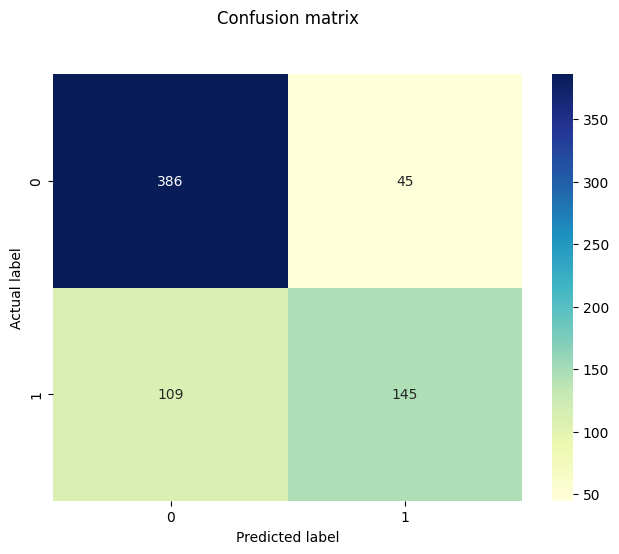

In [101]:
lr_df = performance_metrics(y_pred_lr, y_test, y_train, 'lr')
lr_df

## Ensemble Models 

### Random Forest 

In [105]:
param_grid = [
    {'n_estimators': [50, 100],
     'min_samples_split': [2, 5, 10],
     'max_features': ['sqrt', 'log2'],
     'criterion' : ['gini', 'entropy'],
     'n_jobs': [-1]}
]

rfc = RandomForestClassifier()

rfc_grid_model = GridSearchCV(rfc, 
                              param_grid, 
                              cv=5,
                              scoring='f1',
                              return_train_score=True, 
                              verbose=2)

rfc_grid_model.fit(X_train, 
                  y_train)

best_params = rfc_grid_model.best_params_
print("Best params: ", best_params)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=50, n_jobs=-1; total time=   0.0s
[CV] END criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=50, n_jobs=-1; total time=   0.0s
[CV] END criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=50, n_jobs=-1; total time=   0.0s
[CV] END criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=50, n_jobs=-1; total time=   0.0s
[CV] END criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=50, n_jobs=-1; total time=   0.0s
[CV] END criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.1s
[CV] END criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.1s
[CV] END criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.1s
[CV] END criterion=gini, max_features=s

[CV] END criterion=entropy, max_features=sqrt, min_samples_split=5, n_estimators=50, n_jobs=-1; total time=   0.0s
[CV] END criterion=entropy, max_features=sqrt, min_samples_split=5, n_estimators=50, n_jobs=-1; total time=   0.0s
[CV] END criterion=entropy, max_features=sqrt, min_samples_split=5, n_estimators=50, n_jobs=-1; total time=   0.0s
[CV] END criterion=entropy, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1; total time=   0.1s
[CV] END criterion=entropy, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1; total time=   0.1s
[CV] END criterion=entropy, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1; total time=   0.1s
[CV] END criterion=entropy, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1; total time=   0.1s
[CV] END criterion=entropy, max_features=sqrt, min_samples_split=5, n_estimators=100, n_jobs=-1; total time=   0.1s
[CV] END criterion=entropy, max_features=sqrt, min_samples_split=10, n_esti

In [106]:
rfc = RandomForestClassifier(**best_params)

rfc_model = rfc.fit(X_train, 
                    y_train)

y_pred_rfc = rfc_model.predict(X_test)

Accuracy: 77.96


,Precision,Recall,f1-score
Non-Persistent,0.88,0.79,0.83
Persistent,0.60,0.75,0.67


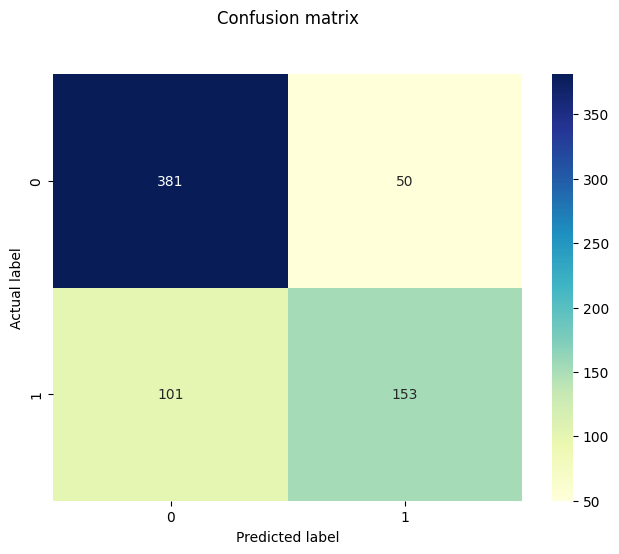

In [107]:
rfc_df = performance_metrics(y_pred_rfc, y_test, y_train, 'rfc')
rfc_df

## Boosting Models 

### AdaBoost 

In [114]:
param_grid = [
    {'base_estimator': [DecisionTreeClassifier(), SVC()],
     'n_estimators': [50, 100],
     'learning_rate': [0.01, 0.1, 1]}
]

adaB = AdaBoostClassifier()

adaB_grid_model = GridSearchCV(adaB, 
                               param_grid, 
                               cv=5,
                               scoring='roc_auc',
#                                return_train_score=True, 
                               n_jobs=-1,
                               verbose=2)

adaB_grid_model.fit(X_train, 
                    y_train)

best_params = adaB_grid_model.best_params_
print("Best params: ", best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params:  {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.01, 'n_estimators': 50}


In [115]:
adaB = AdaBoostClassifier(**best_params)

adaB_model = adaB.fit(X_train, 
                      y_train)

y_pred_adaB = adaB_model.predict(X_test)

Accuracy: 76.06


,Precision,Recall,f1-score
Non-Persistent,0.86,0.78,0.82
Persistent,0.60,0.71,0.65


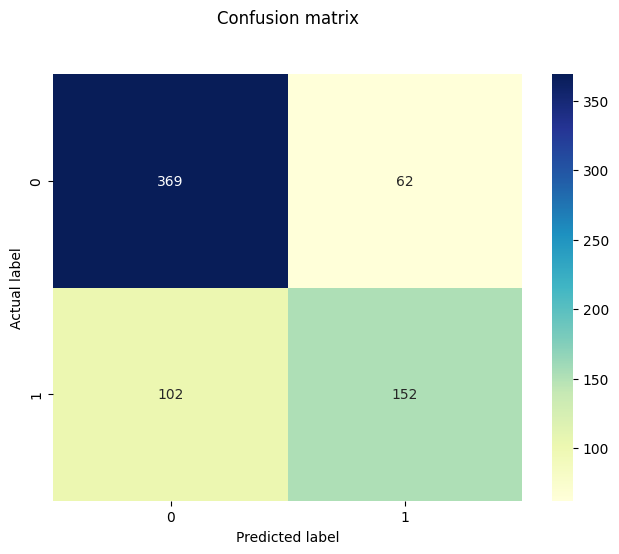

In [116]:
adaB_df = performance_metrics(y_pred_adaB, y_test, y_train, 'adaB')
adaB_df

## XGBoost 

In [33]:
xgb = XGBClassifier()

param_grid = {
    'objective': ['binary:logistic'],  
    'eval_metric': ['merror', 'mlogloss', 'auc'],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100, 200], 
    'use_label_encoder': [False]
}

xgb_grid_model = GridSearchCV(xgb, 
                              param_grid, 
                              cv=5,
                              scoring='f1',
#                               return_train_score=True, 
                              n_jobs=-1,
                              verbose=2)

xgb_grid_model.fit(X_train, 
                   y_train)

best_params = xgb_grid_model.best_params_
print("Best params: ", best_params)

In [ ]:
xgb = XGBClassifier(**best_params)
xgb_model = xgb.fit(X_train, 
                    y_train)
y_pred_xgb = xgb_model.predict(X_test)

Accuracy: 77.52


,Precision,Recall,f1-score
Non-Persistent,0.88,0.79,0.83
Persistent,0.59,0.75,0.66


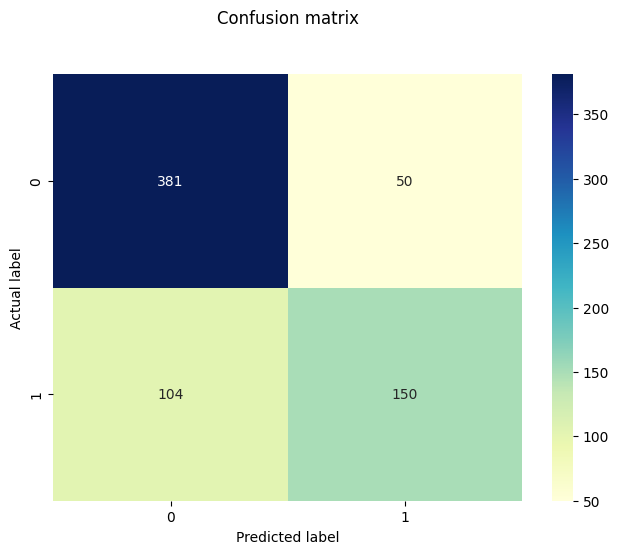

In [35]:
xgb_df = performance_metrics(y_pred_xgb, y_test, y_train, 'xgb')
xgb_df

## 2. Features selected from RFECV: Logistic Regression 

#### Split the Dataset 

In [36]:
target = X_lr['persistency_flag']
X_lr.drop('persistency_flag', 
          axis=1, 
          inplace=True)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_lr, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [25]:
sm = SMOTE(random_state=42,
           n_jobs=-1)

In [26]:
X_train, y_train = sm.fit_resample(X_train, 
                                   y_train)

## Linear Models 

### Logistic Regression 

In [87]:
param_grid = [{
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear'],
    'C' : [1, 10],
}]

lr = LogisticRegression()

lr_grid_model = GridSearchCV(lr, 
                             param_grid, 
                             n_jobs=-1, 
                             scoring='roc_auc',
                             cv=5, 
                             verbose=2)

lr_grid_model.fit(X_train, 
                  y_train)

best_params = lr_grid_model.best_params_
print(best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [88]:
lr  = LogisticRegression(**best_params)
lr_model = lr.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test) 

Accuracy: 80.0


,Precision,Recall,f1-score
Non-Persistent,0.87,0.82,0.85
Persistent,0.68,0.76,0.72


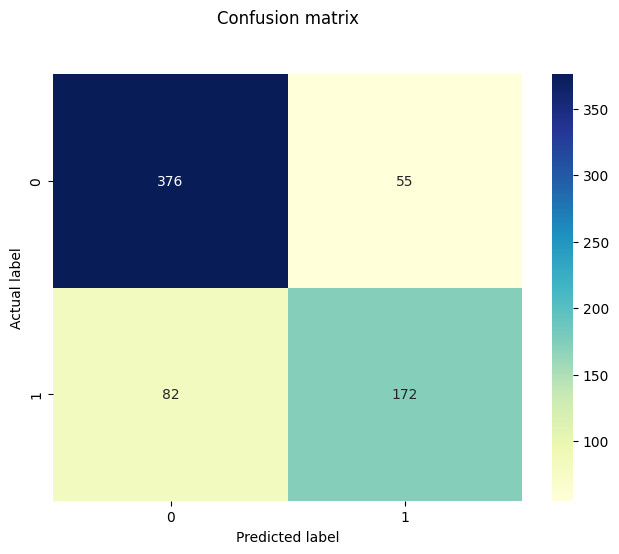

In [89]:
lr_df = performance_metrics(y_pred_lr, y_test, y_train, 'lr')
lr_df

## Ensemble Models 

### Random Forest 

In [78]:
param_grid = [
    {'n_estimators': [50, 100],
     'min_samples_split': [2, 5, 10],
     'max_features': ['sqrt', 'log2'],
     'criterion' : ['gini', 'entropy'],
     'n_jobs': [-1]}
]

rfc = RandomForestClassifier()

rfc_grid_model = GridSearchCV(rfc, 
                              param_grid, 
                              cv=5,
                              scoring='f1', 
                              n_jobs=-1,
#                               return_train_score=True, 
                              verbose=2)

rfc_grid_model.fit(X_train, 
                   y_train)

best_params = rfc_grid_model.best_params_
print("Best params: ", best_params)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params:  {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}


In [79]:
rfc = RandomForestClassifier(**best_params)

rfc_model = rfc.fit(X_train, 
                    y_train)

y_pred_rfc = rfc_model.predict(X_test)

Accuracy: 78.1


,Precision,Recall,f1-score
Non-Persistent,0.87,0.80,0.83
Persistent,0.62,0.75,0.68


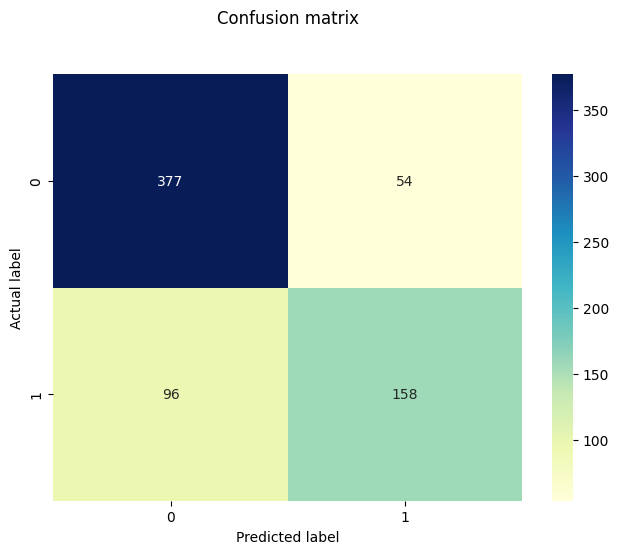

In [80]:
rfc_df = performance_metrics(y_pred_rfc, y_test, y_train, 'rfc')
rfc_df

## Boosting Models 

### AdaBoost 

In [72]:
param_grid = [
    {'base_estimator': [DecisionTreeClassifier(), SVC()],
     'n_estimators': [50, 100],
     'learning_rate': [0.01, 0.1, 1]}
]

adaB = AdaBoostClassifier()

adaB_grid_model = GridSearchCV(adaB, 
                               param_grid, 
                               cv=5,
                               scoring='roc_auc',
                               return_train_score=True, 
                               n_jobs=-1,
                               verbose=2)

adaB_grid_model.fit(X_train, 
                    y_train)

best_params = adaB_grid_model.best_params_
print("Best params: ", best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params:  {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 1, 'n_estimators': 100}


In [73]:
adaB = AdaBoostClassifier(**best_params)

adaB_model = adaB.fit(X_train, 
                      y_train)

y_pred_adaB = adaB_model.predict(X_test)

Accuracy: 76.5


,Precision,Recall,f1-score
Non-Persistent,0.86,0.79,0.82
Persistent,0.61,0.72,0.66


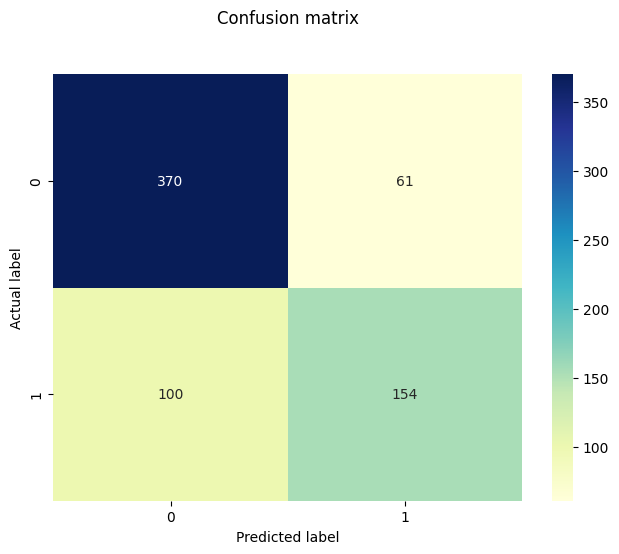

In [74]:
adaB_df = performance_metrics(y_pred_adaB, y_test, y_train, 'adaB')
adaB_df

## XGBoost 

In [61]:
xgb = XGBClassifier()

param_grid = {
    'objective': ['binary:logistic'],  
    'eval_metric': ['merror', 'mlogloss', 'auc'],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100, 200], 
    'use_label_encoder': [False]
}

xgb_grid_model = GridSearchCV(xgb, 
                              param_grid, 
                              cv=5,
                              scoring='f1',
#                               return_train_score=True, 
                              n_jobs=-1,
                              verbose=2)

xgb_grid_model.fit(X_train, 
                   y_train)

best_params = xgb_grid_model.best_params_
print("Best params: ", best_params)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params:  {'eval_metric': 'merror', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'binary:logistic', 'use_label_encoder': False}


In [62]:
xgb = XGBClassifier(**best_params)
xgb_model = xgb.fit(X_train, 
                    y_train)
y_pred_xgb = xgb_model.predict(X_test)

Accuracy: 79.71


,Precision,Recall,f1-score
Non-Persistent,0.88,0.81,0.85
Persistent,0.65,0.77,0.70


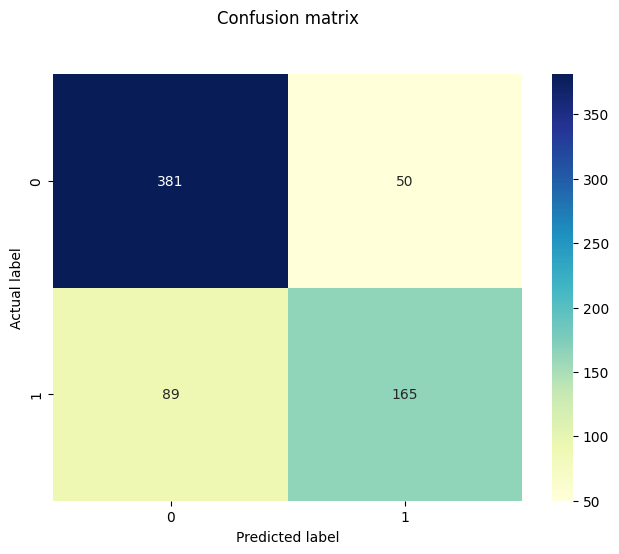

In [63]:
xgb_df = performance_metrics(y_pred_xgb, y_test, y_train, 'xgb')
xgb_df

## 2. Features selected after dropping unnecessary columns

#### Split the Dataset 

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_uptd, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=42)

## Linear Models 

### Logistic Regression 

In [141]:
param_grid = [{
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear'],
    'C' : [1, 10],
}]

lr = LogisticRegression()

lr_grid_model = GridSearchCV(lr, 
                             param_grid, 
                             n_jobs=-1, 
                             scoring='roc_auc',
                             cv=5, 
                             verbose=2)

lr_grid_model.fit(X_train, 
                  y_train)

best_params = lr_grid_model.best_params_
print(best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [142]:
lr  = LogisticRegression(**best_params)
lr_model = lr.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test) 

Accuracy: 80.15


,Precision,Recall,f1-score
Non-Persistent,0.88,0.82,0.85
Persistent,0.67,0.76,0.72


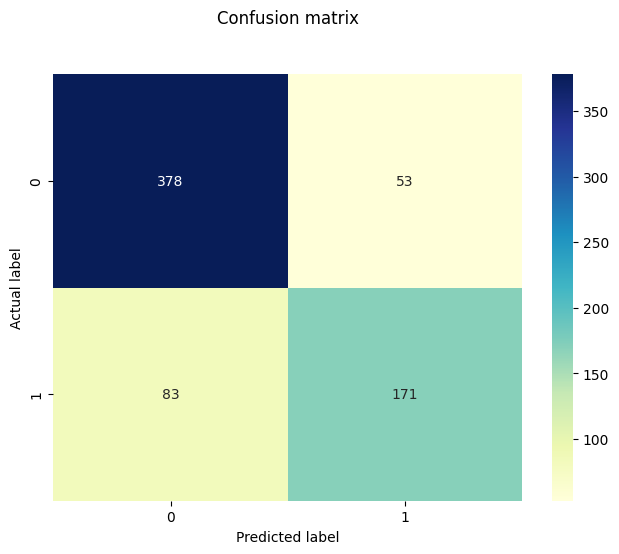

In [143]:
lr_df = performance_metrics(y_pred_lr, y_test, y_train, 'lr')
lr_df

## Ensemble Models 

### Random Forest 

In [153]:
param_grid = [
    {'n_estimators': [50, 100],
     'min_samples_split': [2, 5, 10],
     'max_features': ['sqrt', 'log2'],
     'criterion' : ['gini', 'entropy'],
     'n_jobs': [-1]}
]

rfc = RandomForestClassifier()

rfc_grid_model = GridSearchCV(rfc, 
                              param_grid, 
                              cv=5,
                              scoring='f1', 
                              n_jobs=-1,
#                               return_train_score=True, 
                              verbose=2)

rfc_grid_model.fit(X_train, 
                   y_train)

best_params = rfc_grid_model.best_params_
print("Best params: ", best_params)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params:  {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50, 'n_jobs': -1}


In [154]:
rfc = RandomForestClassifier(**best_params)

rfc_model = rfc.fit(X_train, 
                    y_train)

y_pred_rfc = rfc_model.predict(X_test)

Accuracy: 80.0


,Precision,Recall,f1-score
Non-Persistent,0.88,0.82,0.85
Persistent,0.67,0.76,0.71


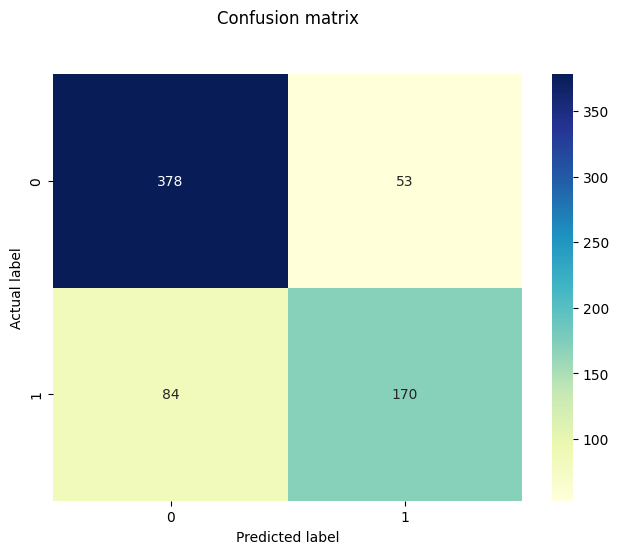

In [155]:
rfc_df = performance_metrics(y_pred_rfc, y_test, y_train, 'rfc')
rfc_df

## Boosting Models 

### AdaBoost 

In [168]:
param_grid = [
    {'base_estimator': [DecisionTreeClassifier(), SVC()],
     'n_estimators': [50, 100],
     'learning_rate': [0.01, 0.1, 1]}
]

adaB = AdaBoostClassifier()

adaB_grid_model = GridSearchCV(adaB, 
                               param_grid, 
                               cv=5,
                               scoring='roc_auc',
                               return_train_score=True, 
                               n_jobs=-1,
                               verbose=2)

adaB_grid_model.fit(X_train, 
                    y_train)

best_params = adaB_grid_model.best_params_
print("Best params: ", best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params:  {'base_estimator': DecisionTreeClassifier(), 'learning_rate': 0.01, 'n_estimators': 50}


In [169]:
adaB = AdaBoostClassifier(**best_params)

adaB_model = adaB.fit(X_train, 
                      y_train)

y_pred_adaB = adaB_model.predict(X_test)

Accuracy: 73.72


,Precision,Recall,f1-score
Non-Persistent,0.79,0.79,0.79
Persistent,0.65,0.64,0.65


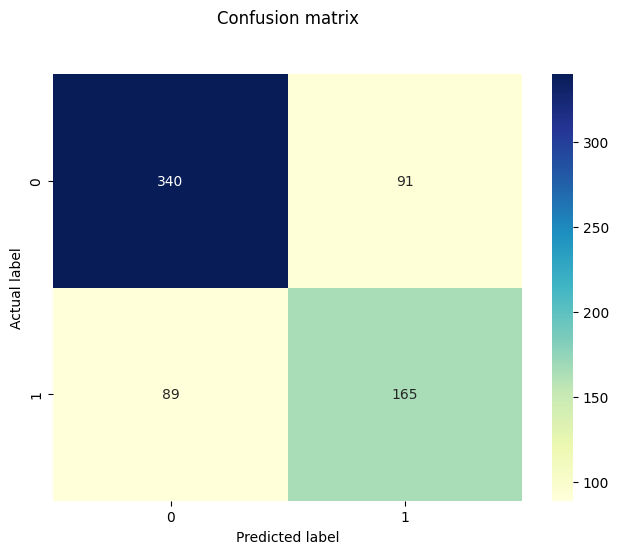

In [170]:
adaB_df = performance_metrics(y_pred_adaB, y_test, y_train, 'adaB')
adaB_df

## XGBoost 

In [171]:
xgb = XGBClassifier()

param_grid = {
    'objective': ['binary:logistic'],  
    'eval_metric': ['merror', 'mlogloss', 'auc'],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100, 200], 
    'use_label_encoder': [False]
}

xgb_grid_model = GridSearchCV(xgb, 
                              param_grid, 
                              cv=5,
                              scoring='f1',
#                               return_train_score=True, 
                              n_jobs=-1,
                              verbose=2)

xgb_grid_model.fit(X_train, 
                   y_train)

best_params = xgb_grid_model.best_params_
print("Best params: ", best_params)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params:  {'eval_metric': 'merror', 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'objective': 'binary:logistic', 'use_label_encoder': False}


In [172]:
xgb = XGBClassifier(**best_params)
xgb_model = xgb.fit(X_train, 
                    y_train)
y_pred_xgb = xgb_model.predict(X_test)

Accuracy: 80.44


,Precision,Recall,f1-score
Non-Persistent,0.88,0.82,0.85
Persistent,0.68,0.77,0.72


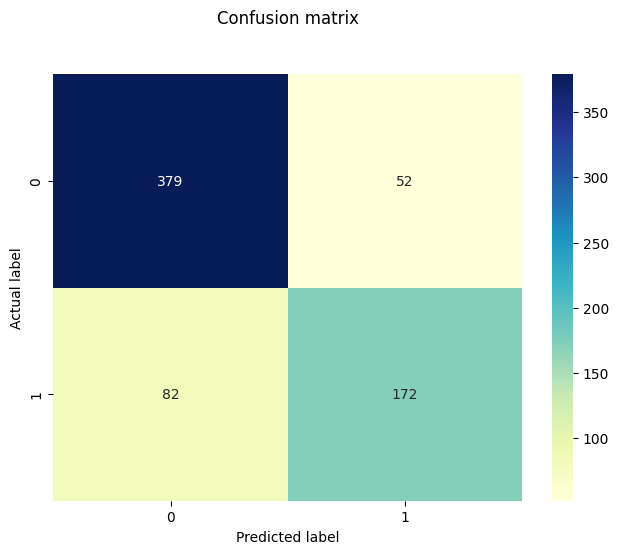

In [173]:
xgb_df = performance_metrics(y_pred_xgb, y_test, y_train, 'xgb')
xgb_df